In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from math import pi
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import FunctionTransformer
from sklearn.tree import DecisionTreeRegressor

from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import OneHotEncoder

import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt


In [44]:
file_path = os.path.join(os.getcwd(), 'AB_NYC_2019.csv')
df = pd.read_csv(file_path)
df.head()

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
2                NaN                               1               365  
3               4.64                               1               194  
4               0.10                               1                 0

In [45]:
df.shape

(48895, 16)

In [46]:
df.drop(columns=['id', 'host_id', 'host_name'], inplace=True)
df.shape

(48895, 13)

In [47]:
print(f"Número de filas duplicadas: {df.duplicated().sum()}")

Número de filas duplicadas: 0


In [48]:
df = df.astype({
    "name": "category",
    "latitude": "float64",
    "longitude": "float64",
    "last_review": "category",
    "reviews_per_month": "float64",
    "room_type": "category",
    "neighbourhood_group": "category",
    "neighbourhood": "category",
    "minimum_nights": "int64",
    "number_of_reviews": "int64",
    "calculated_host_listings_count": "int64",
    "availability_365": "int64",
    "price": "int64"
})

df.dtypes

name                              category
neighbourhood_group               category
neighbourhood                     category
latitude                           float64
longitude                          float64
room_type                         category
price                                int64
minimum_nights                       int64
number_of_reviews                    int64
last_review                       category
reviews_per_month                  float64
calculated_host_listings_count       int64
availability_365                     int64
dtype: object

## EDA

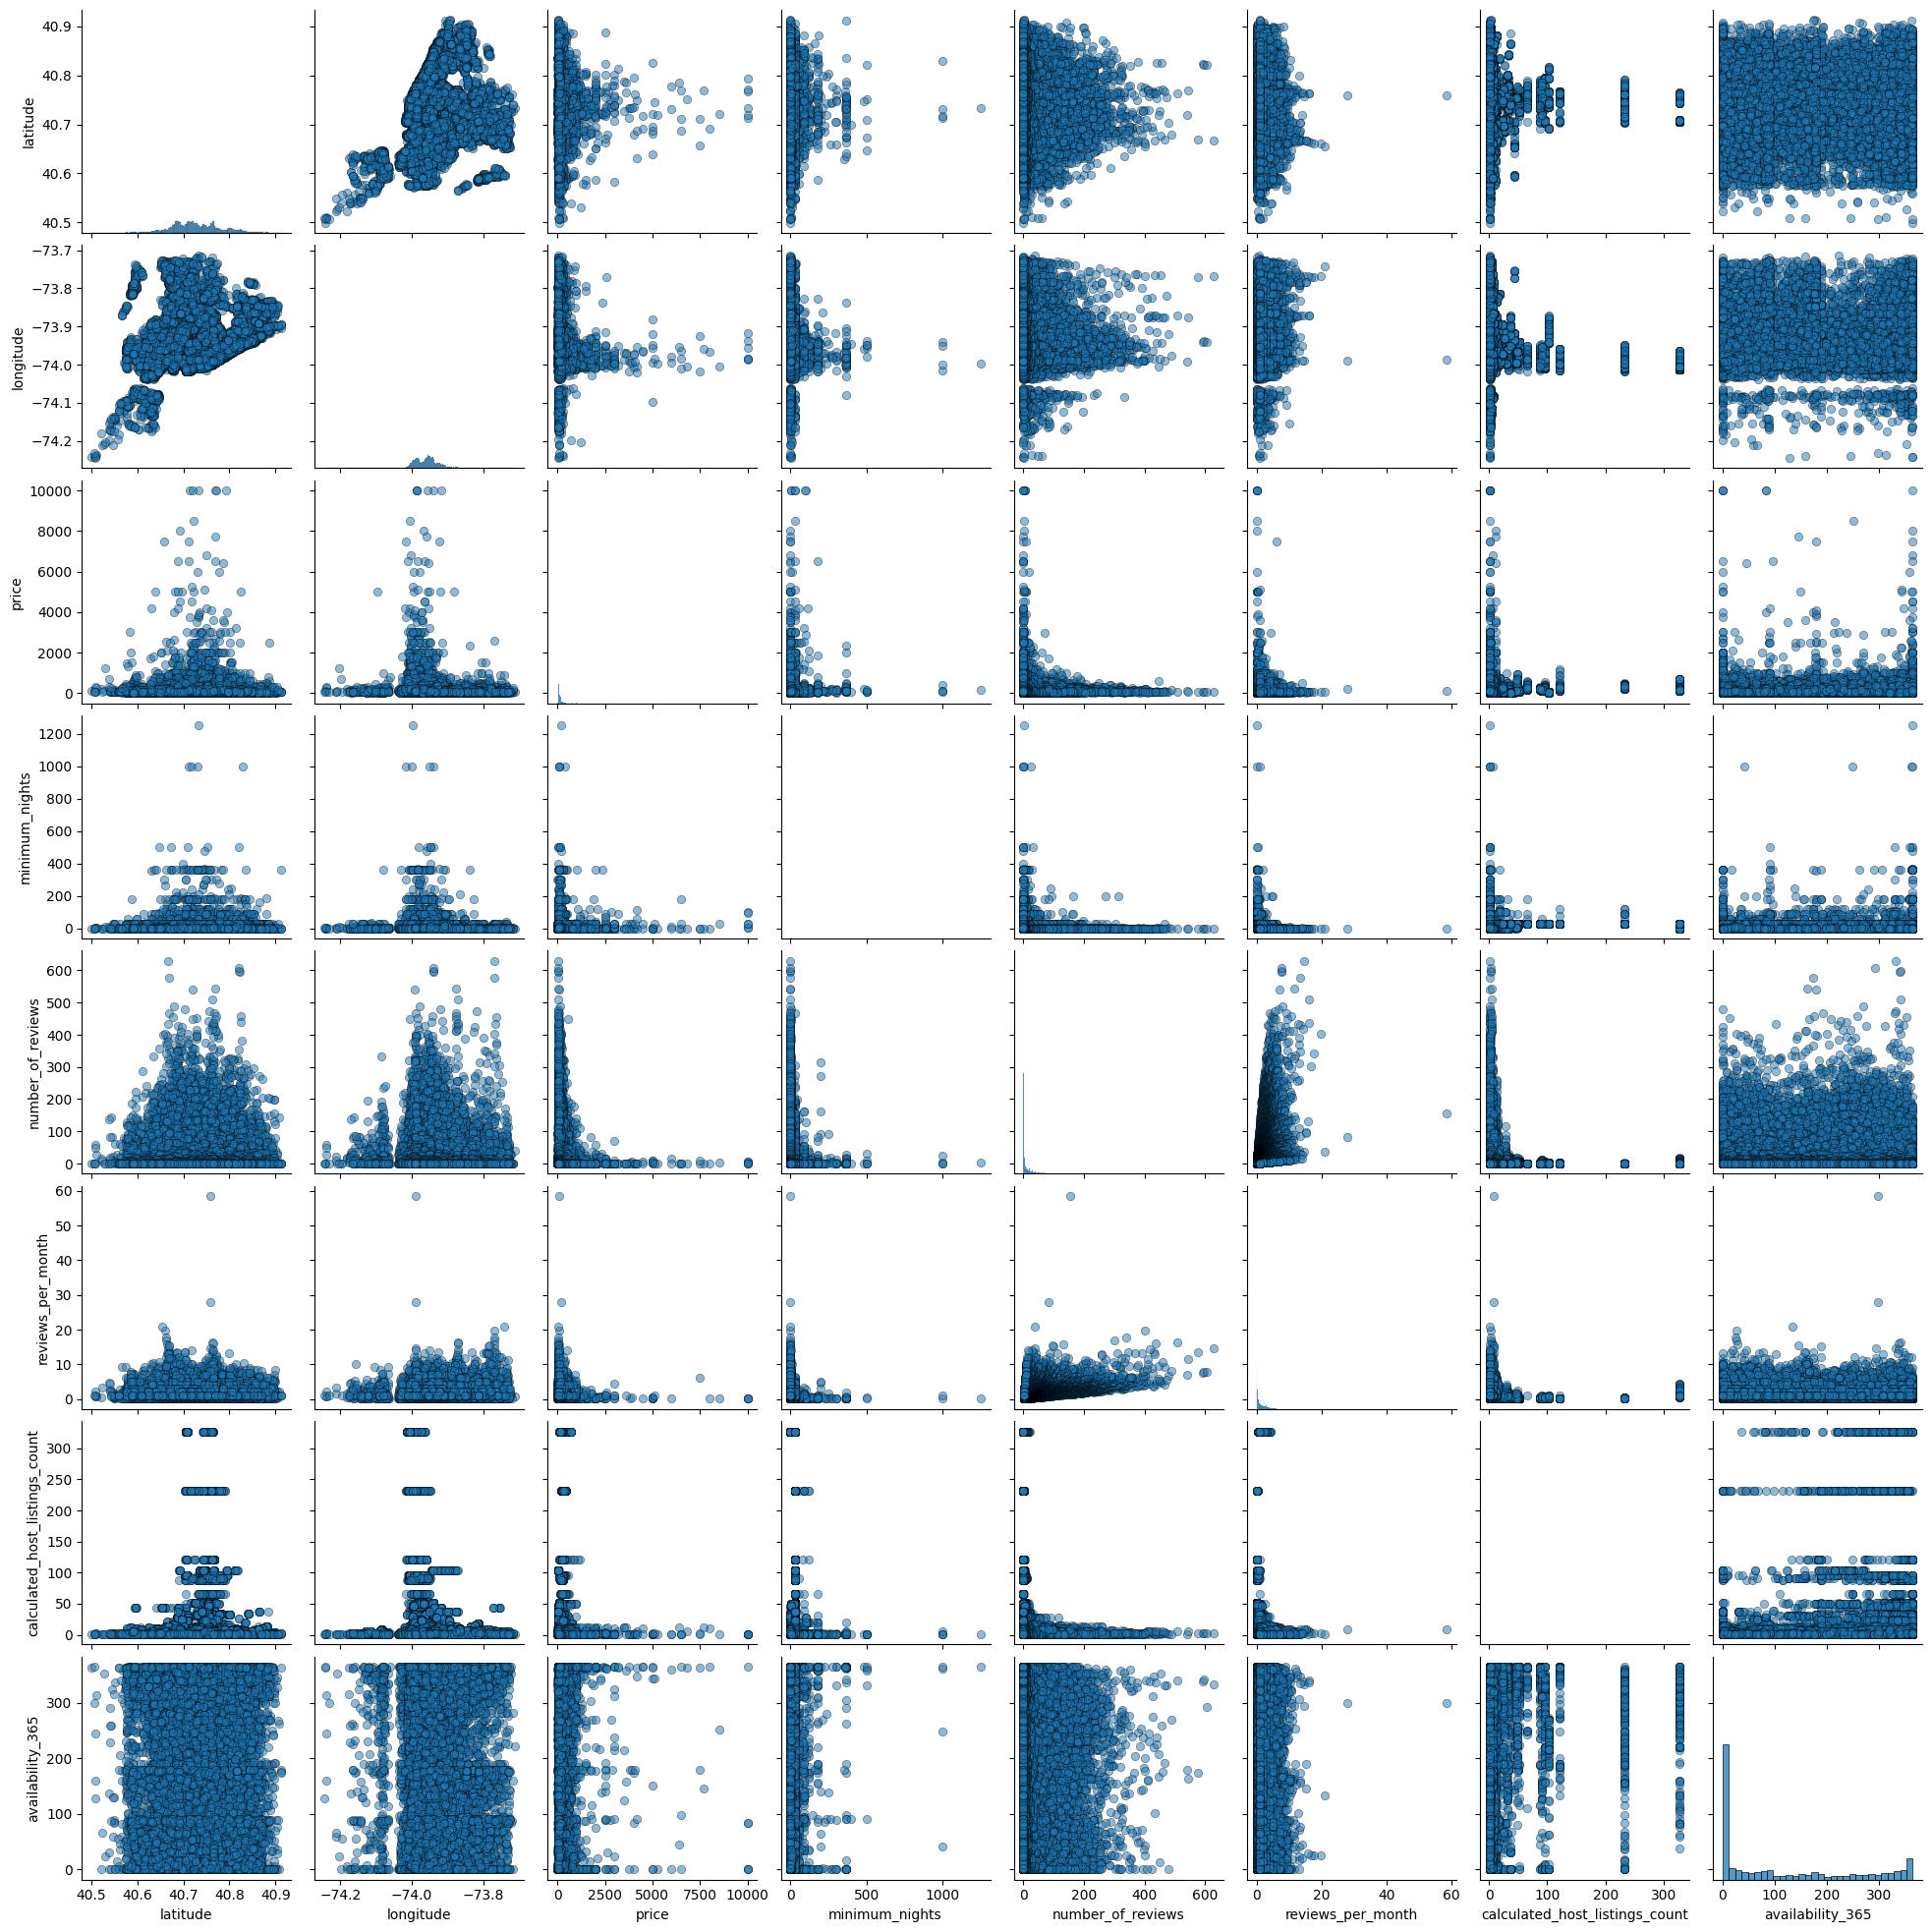

In [49]:
sns.pairplot(df, diag_kind="hist", plot_kws={'alpha': 0.5, 'edgecolor': 'black'})
plt.show()

Buscamos colinealidad y relacion entre objetivo y features

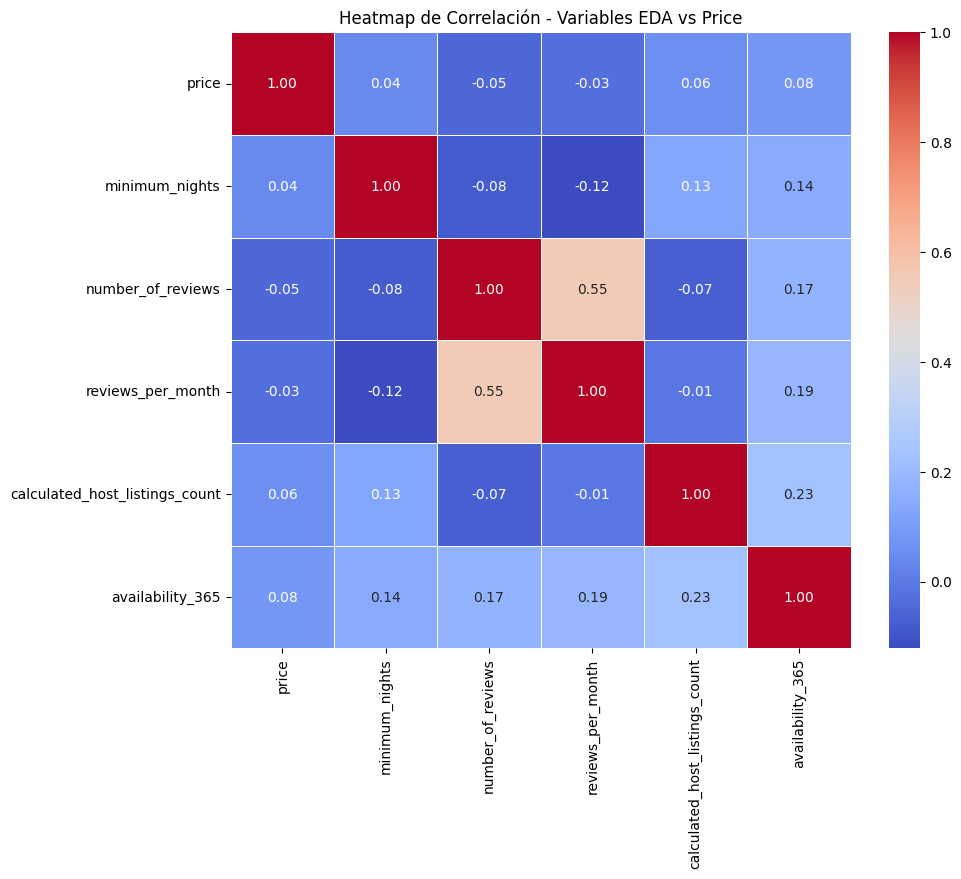

In [50]:
cols = [
    'price',
    'minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'calculated_host_listings_count',
    'availability_365'
]

# Calcular la matriz de correlación
correlation_matrix = df[cols].corr()

# Crear el heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix ,annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmap de Correlación - Variables EDA vs Price")
plt.show()

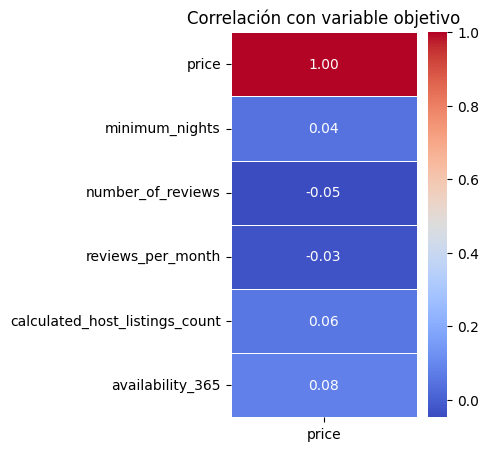

In [51]:
price_corr = correlation_matrix[['price']]
plt.figure(figsize=(3, 5))
sns.heatmap(price_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title("Correlación con variable objetivo")
plt.show()

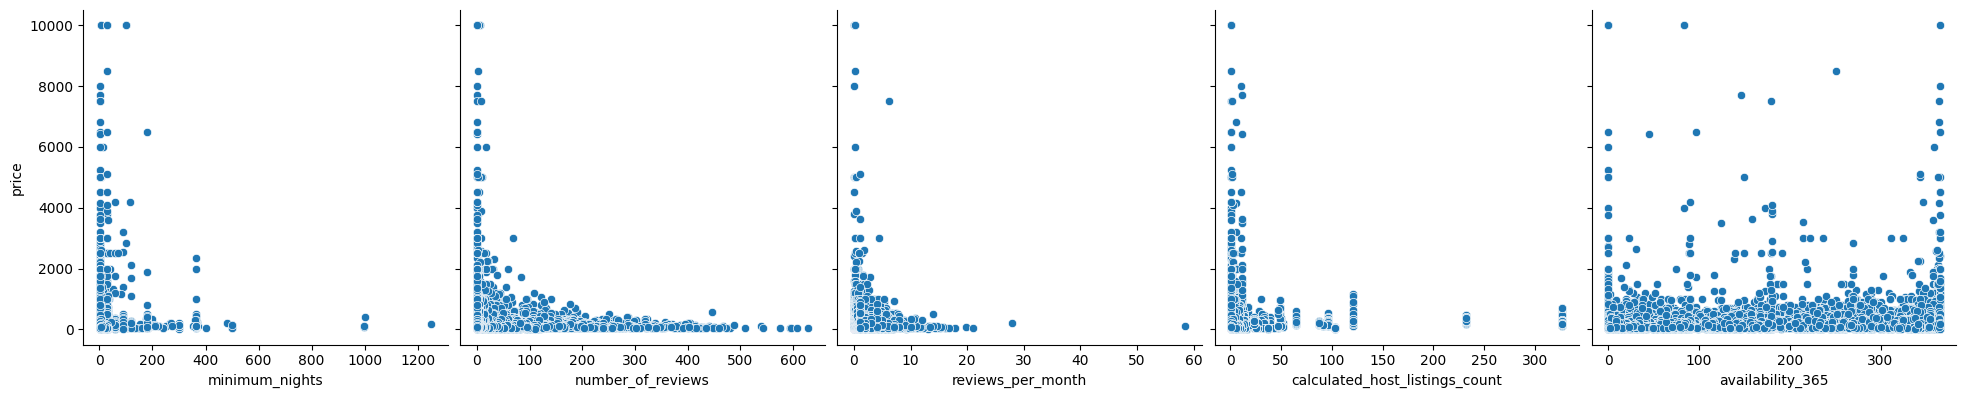

In [52]:
x_vars = [c for c in cols if c != 'price']
y_vars = ['price']

sns.pairplot(
    data=df, 
    x_vars=x_vars, 
    y_vars=y_vars, 
    kind='scatter', 
    height=4, 
    aspect=1
)

plt.show()

In [53]:
df['price'].describe()

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

Observamos una desviacion muy alta con respecto a la media  lo que sugiere que hay una alta variabilidad y presencia de valores extremos en la variable. Además tenemos una distribucion sesgada:

* El percentil 75% es 175, pero el máximo es 10.000  esto indica que hay una cola larga a la derecha.
* La mayoría de los precios están entre 69 y 175, pero algunos pocos valores están muy por encima de 1.000 o incluso 10.000.

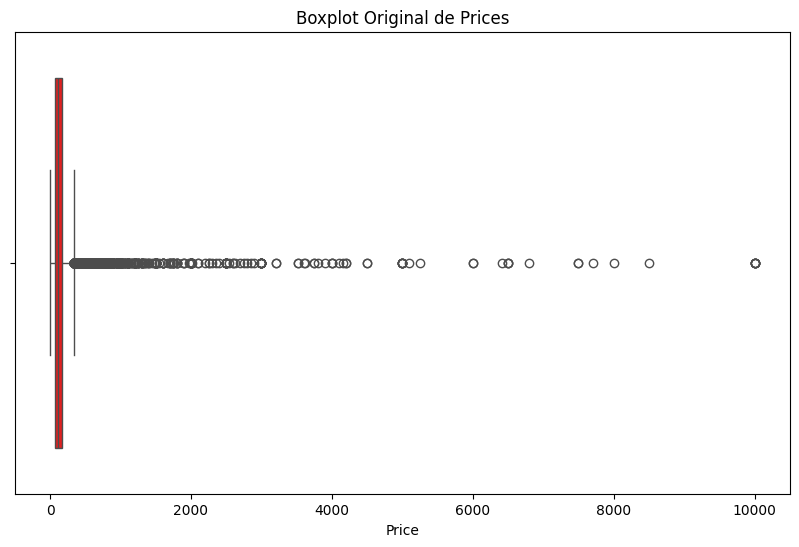

In [54]:

plt.figure(figsize=(10, 6))
sns.boxplot(x=df['price'], color='red')

# Configurar título y etiquetas
plt.title('Boxplot Original de Prices')
plt.xlabel('Price')

# Mostrar gráfico
plt.show()


In [55]:
upper_limit = df['price'].quantile(0.99)  #valores muy extremos
df = df[df['price'] < upper_limit]

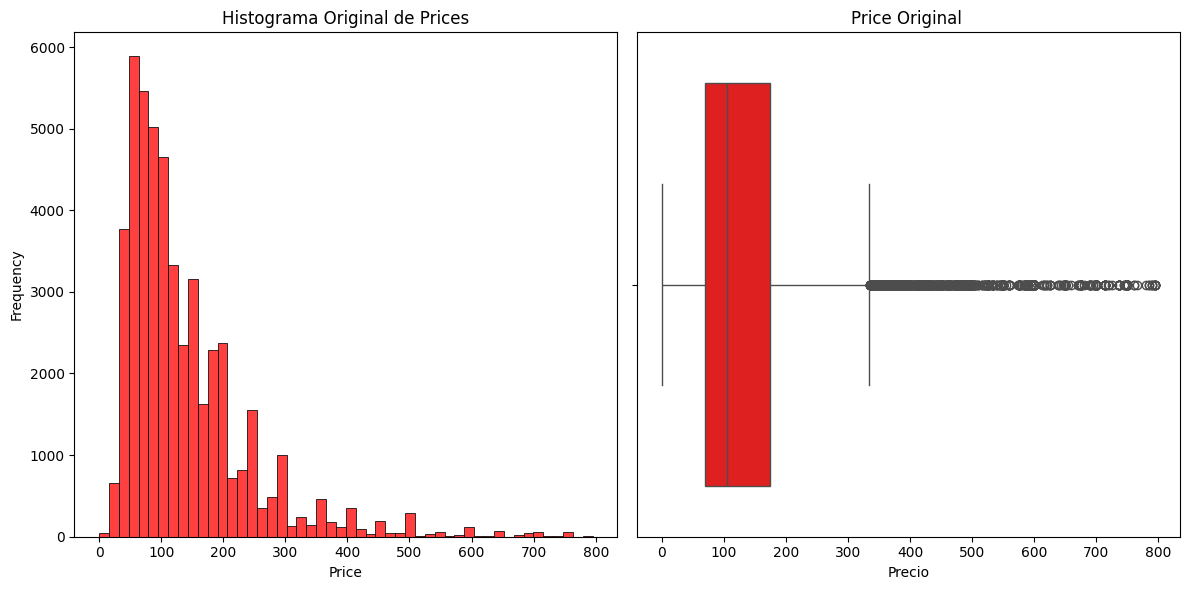

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(df['price'], bins=50, color='red', ax=axes[0])
axes[0].set_title('Histograma Original de Prices')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Frequency')

sns.boxplot(x=df['price'], color='red')
axes[1].set_title('Price Original ')
axes[1].set_xlabel('Precio')



plt.tight_layout()


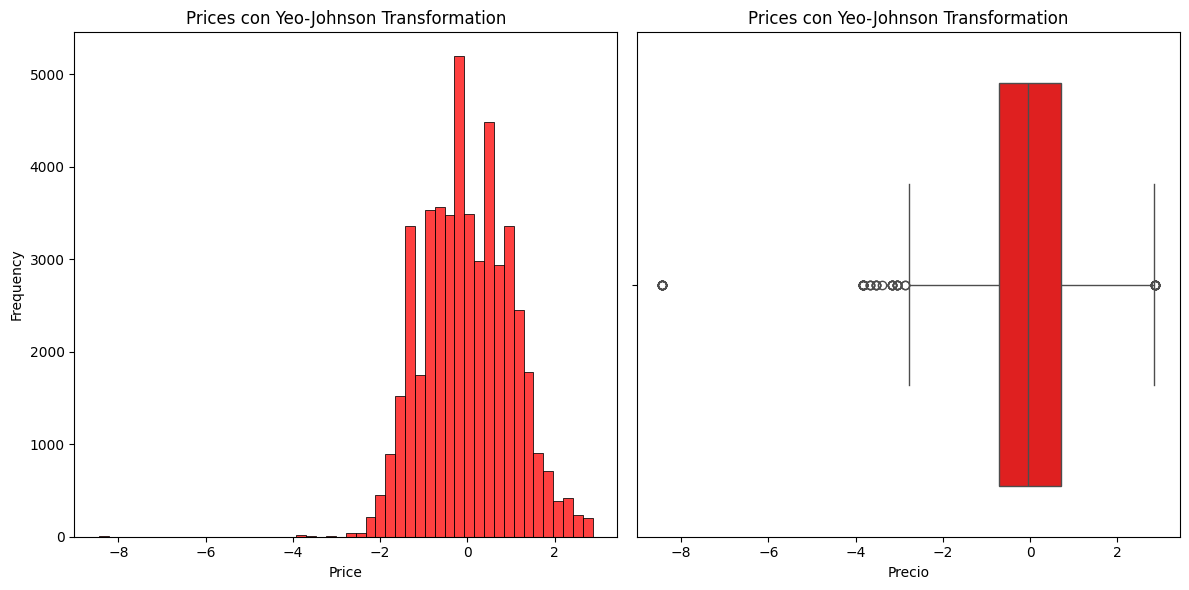

In [57]:
from sklearn.preprocessing import PowerTransformer
transformer = PowerTransformer(method='yeo-johnson')
trans = pd.DataFrame(transformer.fit_transform(df[['price']]), columns=['price'])


fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(trans['price'], bins=50, color='red', ax=axes[0])
axes[0].set_title('Prices con Yeo-Johnson Transformation')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Frequency')

sns.boxplot(x=trans['price'], color='red')
axes[1].set_title('Prices con Yeo-Johnson Transformation')
axes[1].set_xlabel('Precio')



plt.tight_layout()


<Axes: xlabel='room_type', ylabel='count'>

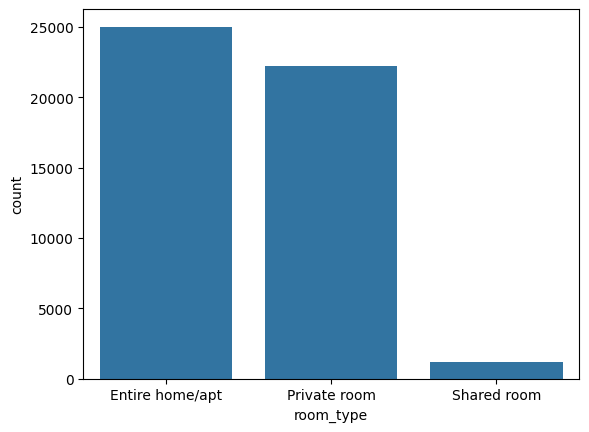

In [58]:
sns.countplot(df, x='room_type')

Se observa desbalanceo entre clases asi que balancearemos en el pìpeline

In [59]:
X = df.drop(columns='price')
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

print(f"X_train : {X_train.shape}, y_train : {y_train.shape}")
print(f"X_test : {X_test.shape}, y_test: {y_test.shape}")


X_train : (38722, 12), y_train : (38722,)
X_test : (9681, 12), y_test: (9681,)


## PREPROCESADO DE X (FEATURES)

Para la imputacion de los valores emplearemos distintas estrategias:
* columna name: usando las coordenadas de las instancias del dataset cercanas.
* columna last_review: usaremos la fecha media del periodo
* columna reviews_per_month: les imputamos 0.0
* columna minimum_nights: aplicamos OnehotEncoder

In [60]:
columnas_originales = X_train.columns.tolist()

cols_originales = [
'name',
'latitude',
'longitude',
'last_review',
'availability_365',
'calculated_host_listings_count', 
'minimum_nights',
'number_of_reviews', 
'reviews_per_month',
'neighbourhood_group',
'neighbourhood',
'room_type',
'price'
]

In [61]:
#columna name imputada segun latitud y longitud con margen de tolerancia
class ImputadorPorCoordenadas(BaseEstimator, TransformerMixin):
    def __init__(self, tolerancia=1e-2):
        self.tolerancia = tolerancia
        self.feature_names_out_ = None

    def fit(self, X, y=None):
        self.X_ = X.copy()
        return self

    def transform(self, X):
    
        X['name'] = X .apply(self._imputar_nombre, axis=1)
    
        return X

    def _imputar_nombre(self, row):
        if pd.isna(row['name']):
            lat, lon = row['latitude'], row['longitude']
            coincidencias = self.X_[
                (np.abs(self.X_['latitude'] - lat) < self.tolerancia) &
                (np.abs(self.X_['longitude'] - lon) < self.tolerancia) &
                self.X_['name'].notna()
            ]
            if not coincidencias.empty:
                return coincidencias['name'].values[0]
        
        return row['name']
    
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_out_



In [62]:
#columna last_review imputada con la fecha media del periodo que involucra el dataset
class DateImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.mean_date_ = None
        self.feature_names_out_ = None
    
    def fit(self, X, y=None):
        X['last_review']= pd.to_datetime(X['last_review'], format='%Y-%m-%d', errors='coerce')
        self.mean_date_ = X['last_review'].dropna().mean()
        return self

    def transform(self, X):   
        X['last_review'] = pd.to_datetime(X['last_review'], format='%Y-%m-%d', errors='coerce')
        X['last_review'] = X['last_review'].fillna(self.mean_date_)
        return X['last_review'].dt.strftime('%Y-%m-%d').values.reshape(-1, 1)
    
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_out_ if self.feature_names_out_ else ["last_review"]

In [63]:

numerical_cols = X_train.select_dtypes(include=[np.number] ).columns
numerical_cols = numerical_cols.difference(['latitude', 'longitude'])

col_reviews_months = Pipeline([
    ('imputador', SimpleImputer(strategy='constant', fill_value=0.0)),
    ('escalador', PowerTransformer(method='yeo-johnson'))
])

ct_custom = ColumnTransformer(
    transformers=[
        ('imputador_name', ImputadorPorCoordenadas(), ['name', 'latitude', 'longitude']),
        ('imputador_last_review', DateImputer(), ['last_review']),
        ('num_pipeline', col_reviews_months, numerical_cols),
        ('OneHotEncoder_room_type', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), ['room_type']),
        ('room_type_original', 'passthrough', ['room_type'])
    ],
    remainder='passthrough',
    n_jobs=-1,
    verbose_feature_names_out=False,
    force_int_remainder_cols=False
)


El pipeline transformador me imputa valores con imputadores personalizados, hace el onehotencoding sobre room_type e imputa a las variables númericas un 0 para finalizar con la transformación con PowerTransformer de las columnas seleccionadas. A su salida, crearé una funcion personalizada para seleccionar las columnas necesarias para la tarea de predcicción o clasificación.

In [64]:
ct_custom

ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                  remainder='passthrough',
                  transformers=[('imputador_name', ImputadorPorCoordenadas(),
                                 ['name', 'latitude', 'longitude']),
                                ('imputador_last_review', DateImputer(),
                                 ['last_review']),
                                ('num_pipeline',
                                 Pipeline(steps=[('imputador',
                                                  SimpleImputer(fill_value=0.0,
                                                                strategy='constant')),
                                                 ('escalador',
                                                  PowerTransformer())]),
                                 Index(['availability_365', 'calculated_host_listings_count', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month'],
      dtype='object')),
                                ('OneHotEncoder_room_type',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['room_type']),
                                ('room_type_original', 'passthrough',
                                 ['room_type'])],
                  verbose_feature_names_out=False)

## REGRESION PRICE

### MEJOR MODELO PARA REGRESION CON GRIDSEARCH


In [65]:
param_grid = [
    {  
        'regressor__modelo': [RandomForestRegressor(random_state=42)],
        'regressor__modelo__n_estimators': [50, 100],         # Menos opciones para reducir la complejidad
        'regressor__modelo__max_depth': [10, 20],              # Eliminamos la opción None para limitar el crecimiento del árbol
        'regressor__modelo__min_samples_split': [4],           # Incrementamos para forzar divisiones con más muestras
        'regressor__modelo__min_samples_leaf': [2],            # Hojas con al menos 2 muestras
        'regressor__modelo__max_features': ['sqrt']            # Fijamos a 'sqrt' para reducir la varianza
    },
    {   
        'regressor__modelo': [DecisionTreeRegressor(random_state=42)],
        'regressor__modelo__max_depth': [10, 20],              # Limitar la profundidad ayuda a evitar el sobreajuste
        'regressor__modelo__min_samples_split': [4],
        'regressor__modelo__min_samples_leaf': [2],
        'regressor__modelo__criterion': ['squared_error']       # Una sola opción para mantener la estabilidad
    }
]


In [66]:
def select_regression_columns(X):
    return X[:, 4:12]


In [67]:
voting_reg = VotingRegressor([
    ('RL_Simple', LinearRegression()),
    ('DecisiónTree', DecisionTreeRegressor(random_state=42)),
    ('RandomForest', RandomForestRegressor(random_state=42))
])


pipeline_regresion = Pipeline([
    ('preprocesamiento', ct_custom),
    ('selector', FunctionTransformer(select_regression_columns)),
    ('modelo', voting_reg)
])


#PREPROCESADO DE 'y' (TARGET) CON TransformedTargetRegressor
regresion_price = TransformedTargetRegressor(
    transformer=PowerTransformer(method='yeo-johnson'),
    regressor=pipeline_regresion,
    check_inverse=False
)


In [68]:
regresion_price

TransformedTargetRegressor(check_inverse=False,
                           regressor=Pipeline(steps=[('preprocesamiento',
                                                      ColumnTransformer(force_int_remainder_cols=False,
                                                                        n_jobs=-1,
                                                                        remainder='passthrough',
                                                                        transformers=[('imputador_name',
                                                                                       ImputadorPorCoordenadas(),
                                                                                       ['name',
                                                                                        'latitude',
                                                                                        'longitude']),
                                                                                      ('imputador_last_review',
                                                                                       DateImputer(),
                                                                                       ['last_review']),
                                                                                      ('num_pipeline',
                                                                                       Pipeline(st...
                                                                                       ['room_type'])],
                                                                        verbose_feature_names_out=False)),
                                                     ('selector',
                                                      FunctionTransformer(func=<function select_regression_columns at 0x000001D73FD1DCA0>)),
                                                     ('modelo',
                                                      VotingRegressor(estimators=[('RL_Simple',
                                                                                   LinearRegression()),
                                                                                  ('DecisiónTree',
                                                                                   DecisionTreeRegressor(random_state=42)),
                                                                                  ('RandomForest',
                                                                                   RandomForestRegressor(random_state=42))]))]),
                           transformer=PowerTransformer())

In [69]:
regresion_voting_GridSearch = GridSearchCV(regresion_price, param_grid, cv=5, scoring='r2', n_jobs=-1) #con validacion cruzada de 5

In [70]:
regresion_voting_GridSearch.fit(X_train, y_train)

print("Mejores parámetros:", regresion_voting_GridSearch.best_params_)
print("Mejor R2 en validación:", regresion_voting_GridSearch.best_score_)



Mejores parámetros: {'regressor__modelo': RandomForestRegressor(random_state=42), 'regressor__modelo__max_depth': 20, 'regressor__modelo__max_features': 'sqrt', 'regressor__modelo__min_samples_leaf': 2, 'regressor__modelo__min_samples_split': 4, 'regressor__modelo__n_estimators': 100}
Mejor R2 en validación: 0.3367412193677554


In [71]:
#evaluacion de regresion en X_test
from sklearn.metrics import  r2_score, mean_absolute_error, root_mean_squared_error
import numpy as np

#  predicciones en test
y_pred_test = regresion_voting_GridSearch.predict(X_test)

df_resultados = pd.DataFrame(columns=['Modelo', 'R2', 'MAE', 'RMSE'])

print(y_pred_test.shape)

r2 = r2_score(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
rmse = root_mean_squared_error(y_test, y_pred_test)


df_resultados.loc[len(df_resultados)] = ['VotingRegressor', r2, mae, rmse]
df_resultados


(9681,)


Modelo        R2        MAE       RMSE
0  VotingRegressor  0.363954  49.643755  84.095483

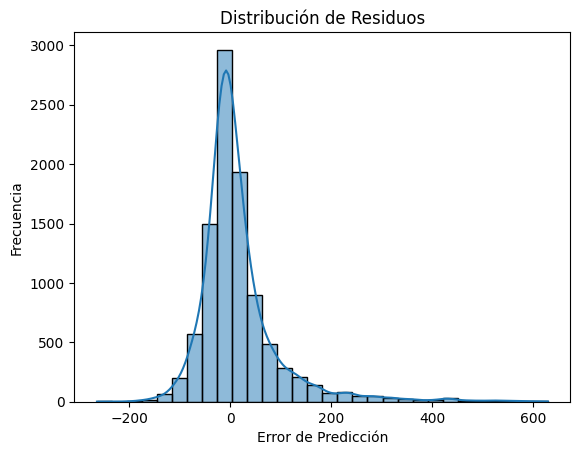

In [72]:



#análisis de errores
residuos = y_test - y_pred_test
sns.histplot(residuos, bins=30, kde=True)
plt.xlabel("Error de Predicción")
plt.ylabel("Frecuencia")
plt.title("Distribución de Residuos")
plt.show()

## CLASIFICACION ROOM_TYPE

In [73]:
df_clasificacion = df.copy()
X = df_clasificacion.drop(columns=['room_type'], axis=1)
y = df_clasificacion['room_type']


X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
print(f"X_train : {X_train_c.shape}, y_train : {y_train_c.shape}")


X_train : (38722, 12), y_train : (38722,)


In [74]:
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
categorical_cols_c = X_train_c.select_dtypes(exclude=[np.number] ).columns
categorical_cols_c = categorical_cols_c.difference(['name','neighbourhood_group', 'neighbourhood'])

numerical_cols_c = X_train_c.select_dtypes(include=[np.number]).columns


pipeline_numerical = make_pipeline(
    SimpleImputer(strategy='constant', fill_value=0.0),
    StandardScaler()
)


pipeline_categorical = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(sparse_output=False, handle_unknown='ignore')
)

pipeline_all = ColumnTransformer([
    ('numeric', pipeline_numerical, numerical_cols_c),
    ('categorical', pipeline_categorical, categorical_cols_c)
])

pipeline_c = ImbPipeline([
    ('preprocessing', pipeline_all),
    ('modelo', KNeighborsClassifier(n_neighbors=5))
])


pipeline_c.fit(X_train_c, y_train_c)
y_pred_c = pipeline_c.predict(X_test_c)


In [75]:
from sklearn.metrics import classification_report


print(classification_report(y_test_c, y_pred_c))

                 precision    recall  f1-score   support

Entire home/apt       0.80      0.79      0.79      5003
   Private room       0.74      0.78      0.76      4447
    Shared room       0.67      0.14      0.24       231

       accuracy                           0.77      9681
      macro avg       0.74      0.57      0.60      9681
   weighted avg       0.77      0.77      0.76      9681



## MODELADO kmeans sobre datos orignales



In [76]:
df.dtypes

name                              category
neighbourhood_group               category
neighbourhood                     category
latitude                           float64
longitude                          float64
room_type                         category
price                                int64
minimum_nights                       int64
number_of_reviews                    int64
last_review                       category
reviews_per_month                  float64
calculated_host_listings_count       int64
availability_365                     int64
dtype: object

In [77]:
df.head(1)

name neighbourhood_group neighbourhood  \
0  Clean & quiet apt home by the park            Brooklyn    Kensington   

   latitude  longitude     room_type  price  minimum_nights  \
0  40.64749  -73.97237  Private room    149               1   

   number_of_reviews last_review  reviews_per_month  \
0                  9  2018-10-19               0.21   

   calculated_host_listings_count  availability_365  
0                               6               365

In [78]:
from kneed import KneeLocator
from sklearn.base import ClusterMixin
class OptimalKMeans(BaseEstimator, ClusterMixin):
    def __init__(self, k_min=2, k_max=10, random_state=None):
        self.k_min = k_min
        self.k_max = k_max
        self.random_state = random_state
        self.optimal_k_ = None
        self.kmeans_ = None

    def fit(self, X, y=None):
        inertias = []
        k_range = range(self.k_min, self.k_max + 1)
        for k in k_range:
            km = KMeans(n_clusters=k, random_state=self.random_state)
            km.fit(X)
            inertias.append(km.inertia_)


        try:
            
            kl = KneeLocator(list(k_range), inertias, curve='convex', direction='decreasing')
            self.optimal_k_ = kl.elbow if kl.elbow is not None else self.k_min
        except ImportError:
            print("La librería 'kneed' no está instalada. Se usará k_min como valor óptimo.")
            self.optimal_k_ = self.k_min

        # Ajustar KMeans con el k óptimo encontrado
        self.kmeans_ = KMeans(n_clusters=self.optimal_k_, random_state=self.random_state)
        self.kmeans_.fit(X)
        return self

    def predict(self, X):
        return self.kmeans_.predict(X)

    def fit_predict(self, X, y=None):
        self.fit(X, y)
        return self.predict(X)

    def transform(self, X):
        
        return X

    def get_params(self, deep=True):
        return {"k_min": self.k_min, "k_max": self.k_max, "random_state": self.random_state}

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

In [79]:
#aplico el pipeline de transformacion sobre df

ct_custom_kmean = ColumnTransformer(
    transformers=[
        ('imputador_name', ImputadorPorCoordenadas(), ['name', 'latitude', 'longitude']),
        ('imputador_last_review', DateImputer(), ['last_review']),
        ('imputador', SimpleImputer(strategy='constant', fill_value=0.0), numerical_cols)
    ],
    remainder='passthrough',
    n_jobs=-1,
    verbose_feature_names_out=False,
    force_int_remainder_cols=False
)

def select_cols_kmean(X):
    numeric_indices = []
    for i in range(X.shape[1]):
        try:
            X[:, i].astype(float)
            numeric_indices.append(i)
        except (ValueError, TypeError):  # Si falla, se considera la columna como categórica y se descarta
            continue
    return X[:, numeric_indices]


pipeline_kmeans = Pipeline([
    ('preprocesamiento', ct_custom_kmean),
    ('selec_numertical', FunctionTransformer(select_cols_kmean)),
    ('optimal_kmeans', OptimalKMeans(k_min=2, k_max=10, random_state=42))
])

pipeline_kmeans

Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                                   remainder='passthrough',
                                   transformers=[('imputador_name',
                                                  ImputadorPorCoordenadas(),
                                                  ['name', 'latitude',
                                                   'longitude']),
                                                 ('imputador_last_review',
                                                  DateImputer(),
                                                  ['last_review']),
                                                 ('imputador',
                                                  SimpleImputer(fill_value=0.0,
                                                                strategy='constant'),
                                                  Index(['availability_365', 'calculated_host_listings_count', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('selec_numertical',
                 FunctionTransformer(func=<function select_cols_kmean at 0x000001D734EB9DC0>)),
                ('optimal_kmeans', OptimalKMeans(random_state=42))])

In [80]:
df_limpio = pipeline_kmeans.fit_transform(df)
df_limpio = pd.DataFrame(df_limpio, columns=['latitude', 
                                             'longitude',
                                             'availability_365',
                                             'calculated_host_listings_count',
                                             'minimum_nights', 
                                             'number_of_reviews',
                                             'reviews_per_month', 
                                             'price'
                                             ])



clusters = pipeline_kmeans.predict(df)
clusters = pd.DataFrame(clusters, columns=['clusters'])

df_limpio = pd.concat([df_limpio, clusters], axis=1)

print(f"K_optimo calculado: {pipeline_kmeans.named_steps['optimal_kmeans'].optimal_k_}")
print(df_limpio['clusters'].astype('category').unique())  


df_limpio.head()

K_optimo calculado: 4
[1, 0, 3, 2]
Categories (4, int32): [0, 1, 2, 3]


latitude longitude availability_365 calculated_host_listings_count  \
0  40.64749 -73.97237            365.0                            6.0   
1  40.75362 -73.98377            355.0                            2.0   
2  40.80902  -73.9419            365.0                            1.0   
3  40.68514 -73.95976            194.0                            1.0   
4  40.79851 -73.94399              0.0                            1.0   

  minimum_nights number_of_reviews reviews_per_month price  clusters  
0            1.0               9.0              0.21   149         1  
1            1.0              45.0              0.38   225         1  
2            3.0               0.0               0.0   150         1  
3            1.0             270.0              4.64    89         1  
4           10.0               9.0               0.1    80         0

Silhouette score promedio para k = 4: 0.433


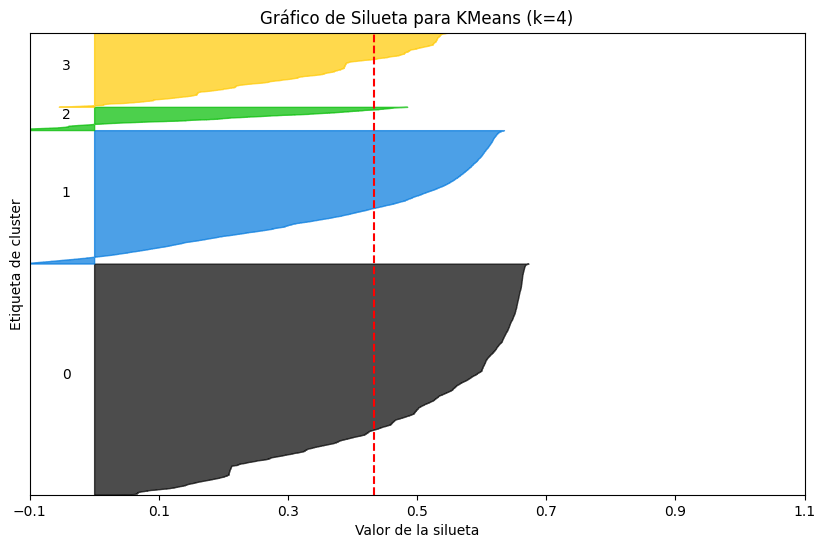

In [81]:

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm


# Extraer las variables numéricas usadas para clustering (sin la columna 'clusters')
# Asumimos que df_limpio es el DataFrame resultante del pipeline y contiene las columnas originales.
X = df_limpio.drop('clusters', axis=1).values

# Extraer las etiquetas de cluster (convertidas a int)
labels = df_limpio['clusters'].astype(int).values

# Número de clusters (según lo calculado por OptimalKMeans)
n_clusters = pipeline_kmeans.named_steps['optimal_kmeans'].optimal_k_

# Calcular la silueta promedio
silhouette_avg = silhouette_score(X, labels)
print(f"Silhouette score promedio para k = {n_clusters}: {silhouette_avg:.3f}")

# Calcular la silueta para cada muestra
sample_silhouette_values = silhouette_samples(X, labels)

# Crear el gráfico de silueta
fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))

# Definir límites del eje x y eje y
ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])

y_lower = 10
for i in range(n_clusters):
    # Extraer y ordenar los valores de silueta del cluster i
    ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Etiquetar el cluster en el eje y
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # Espacio entre clusters

# Dibujar la línea de la silueta promedio
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_title(f"Gráfico de Silueta para KMeans (k={n_clusters})")
ax1.set_xlabel("Valor de la silueta")
ax1.set_ylabel("Etiqueta de cluster")

# Eliminar las marcas del eje y para una visualización más limpia
ax1.set_yticks([])
ax1.set_xticks(np.arange(-0.1, 1.1, 0.2))

plt.show()

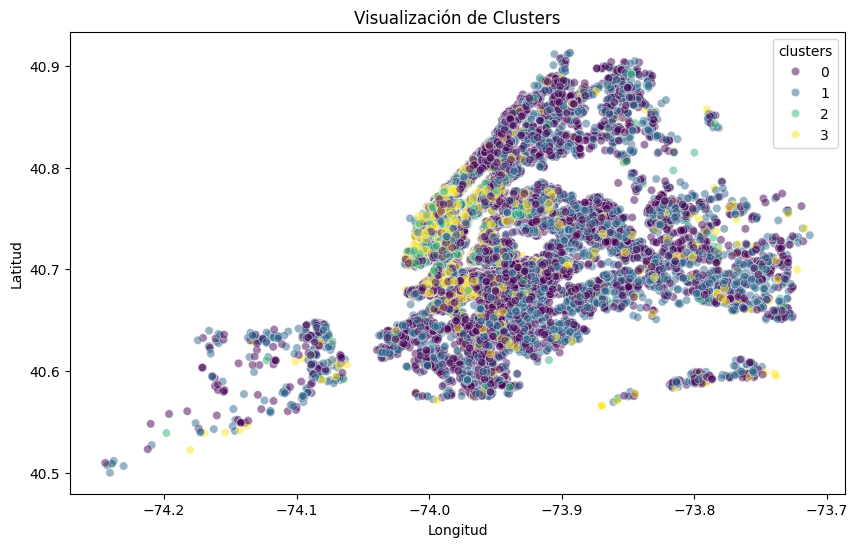

In [82]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='longitude', y='latitude', hue='clusters', palette='viridis', data=df_limpio, alpha=0.5)
plt.title("Visualización de Clusters")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

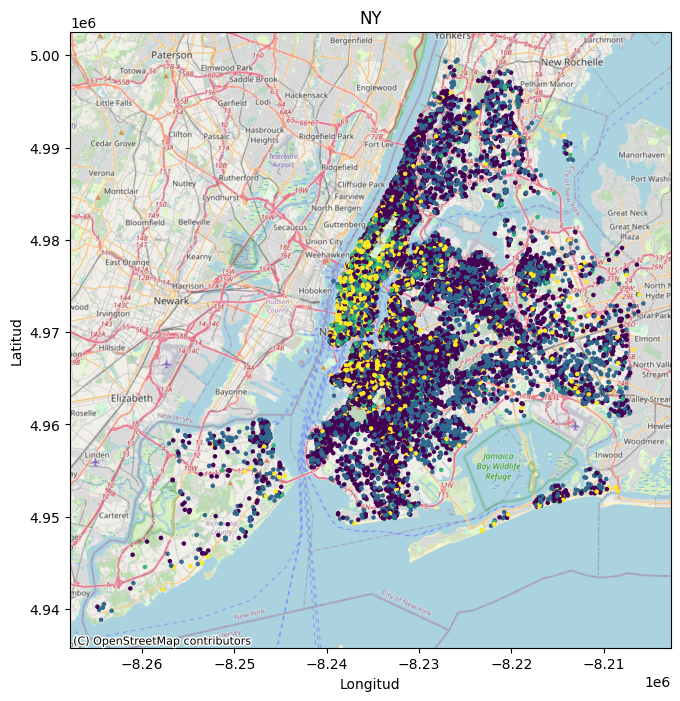

In [83]:
gdf = gpd.GeoDataFrame(
    df_limpio, 
    geometry=gpd.points_from_xy(df_limpio['longitude'], df_limpio['latitude'])
)

gdf.set_crs(epsg=4326, inplace=True)
gdf = gdf.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(14, 8))
gdf.plot(
    column='clusters', 
    ax=ax, 
    cmap='viridis', 
    markersize=5, 
    legend= False
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title("NY")
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")

plt.show()


## Selección de características con KBest

In [84]:
#usamos el pipeline de transformacion con datos originales

import re
from unicodedata import numeric

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
col_numerics = Pipeline([
    ('imputador', SimpleImputer(strategy='constant', fill_value=0.0)),
    ('escalador_pca_X', StandardScaler())
])

ct_custom_kbest = ColumnTransformer(
    transformers=[
        ('imputador_name', ImputadorPorCoordenadas(), ['name', 'latitude', 'longitude']),
        ('imputador_last_review', DateImputer(), ['last_review']),
        ('num_pipeline', col_numerics, numerical_cols),
        ('OneHotEncoder_room_type', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), ['room_type']),
        ('room_type_original', 'passthrough', ['room_type'])
    ],
    remainder='passthrough',
    n_jobs=-1,
    verbose_feature_names_out=False,
    force_int_remainder_cols=False
)

    
pipeline_kbest = Pipeline([
    ('preprocesamiento', ct_custom_kbest),
    ('selector_numeruicas', FunctionTransformer(select_cols_kmean)),
    ('featurtes_selection', SelectKBest(f_regression, k=8)), #necesita la variable objetivo
    ('modelo', RandomForestRegressor(random_state=42))
])

pipeline_kbest_fin = TransformedTargetRegressor(
    transformer=StandardScaler(),
    regressor=pipeline_kbest
)

pipeline_kbest_fin

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocesamiento',
                                                      ColumnTransformer(force_int_remainder_cols=False,
                                                                        n_jobs=-1,
                                                                        remainder='passthrough',
                                                                        transformers=[('imputador_name',
                                                                                       ImputadorPorCoordenadas(),
                                                                                       ['name',
                                                                                        'latitude',
                                                                                        'longitude']),
                                                                                      ('imputador_last_review',
                                                                                       DateImputer(),
                                                                                       ['last_review']),
                                                                                      ('num_pipeline',
                                                                                       Pipeline(steps=[('imputador',
                                                                                                        Si...
                                                                                      ('room_type_original',
                                                                                       'passthrough',
                                                                                       ['room_type'])],
                                                                        verbose_feature_names_out=False)),
                                                     ('selector_numeruicas',
                                                      FunctionTransformer(func=<function select_cols_kmean at 0x000001D734EB9DC0>)),
                                                     ('featurtes_selection',
                                                      SelectKBest(k=8,
                                                                  score_func=<function f_regression at 0x000001D740DDEE50>)),
                                                     ('modelo',
                                                      RandomForestRegressor(random_state=42))]),
                           transformer=StandardScaler())

In [85]:
pipeline_kbest_fin.fit(X_train, y_train)
y_pred_test = pipeline_kbest_fin.predict(X_test)

In [86]:
r2 = r2_score(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
rmse = root_mean_squared_error(y_test, y_pred_test)
df_resultados.loc[len(df_resultados)] = ['RandomForestRegressor_KBest', r2, mae, rmse]

## Uso de PCA

In [87]:
pipeline_pca = Pipeline([
    ('preprocesamiento', ct_custom_kbest),
    ('selector_numeruicas', FunctionTransformer(select_cols_kmean)),
    ('pca', PCA(n_components=4)),
    ('modelo', RandomForestRegressor(random_state=42))
])

pipeline_pca

Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                                   remainder='passthrough',
                                   transformers=[('imputador_name',
                                                  ImputadorPorCoordenadas(),
                                                  ['name', 'latitude',
                                                   'longitude']),
                                                 ('imputador_last_review',
                                                  DateImputer(),
                                                  ['last_review']),
                                                 ('num_pipeline',
                                                  Pipeline(steps=[('imputador',
                                                                   SimpleImputer(fill_value=0.0,
                                                                                 strategy='...
                                                 ('OneHotEncoder_room_type',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['room_type']),
                                                 ('room_type_original',
                                                  'passthrough',
                                                  ['room_type'])],
                                   verbose_feature_names_out=False)),
                ('selector_numeruicas',
                 FunctionTransformer(func=<function select_cols_kmean at 0x000001D734EB9DC0>)),
                ('pca', PCA(n_components=4)),
                ('modelo', RandomForestRegressor(random_state=42))])

In [88]:
pipeline_pca.fit(X_train, y_train)
y_pred_test = pipeline_pca.predict(X_test)
r2 = r2_score(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
rmse = root_mean_squared_error(y_test, y_pred_test)


df_resultados.loc[len(df_resultados)] = ['RandomForestRegressor_PCA_4', r2, mae, rmse]


## Comparativa

In [89]:
models = {
    "RandomForestRegressor_KBest": pipeline_kbest_fin,
    "VotingRegressor": regresion_price,
    "RandomForestRegressor_PCA_4": pipeline_pca
}

scoring = {
    "R2": "r2",
    "MAE": "neg_mean_absolute_error",
    "RMSE": "neg_root_mean_squared_error"
}



In [90]:
from sklearn.model_selection import KFold, cross_validate

cv = KFold(n_splits=10, shuffle=True, random_state=42)
results = {}
df_list = []

for name, model in models.items():
    cv_results = cross_validate(model, X_test, y_test, cv=cv, scoring=scoring, n_jobs=-1)
    
    df_model = pd.DataFrame(cv_results)
    
    if 'test_MAE' in df_model.columns:
        df_model['test_MAE'] = -df_model['test_MAE']
    if 'test_RMSE' in df_model.columns:
        df_model['test_RMSE'] = -df_model['test_RMSE']
        
    df_model['modelo (test)'] = name
    df_list.append(df_model)

df_resultados = pd.concat(df_list, ignore_index=True)

In [91]:
df_resultados

fit_time  score_time   test_R2   test_MAE  test_RMSE  \
0   7.646869    0.287218  0.447058  48.790041  78.884210   
1   8.146737    0.097739  0.442770  52.220527  84.061441   
2   6.724269    0.833306  0.477211  50.044587  79.168797   
3   7.017114    0.401797  0.394634  46.677789  76.536554   
4   5.398557    0.548661  0.402316  52.669390  82.312122   
5   5.610033    0.444747  0.330424  50.313750  82.008938   
6   7.149889    0.079902  0.456311  46.528202  74.985437   
7   6.796660    0.084115  0.423696  53.112624  83.472909   
8   5.900687    0.087102  0.391689  51.022407  79.656286   
9   4.907941    0.341088  0.383915  49.122893  83.174737   
10  4.277365    1.028379  0.298329  54.123245  88.862193   
11  3.446803    1.695208  0.273945  58.472485  95.954297   
12  4.198657    1.019004  0.306579  54.531983  91.177815   
13  5.269261    0.222235  0.262579  51.166101  84.472926   
14  6.181484    0.665221  0.314571  55.961808  88.147382   
15  5.212685    0.118266  0.255087  52.800091  86.499588   
16  3.517769    0.092924  0.310784  51.594022  84.426606   
17  3.547692    0.064953  0.301656  55.216194  91.887021   
18  3.749382    0.078019  0.263787  53.970722  87.631195   
19  3.407704    0.062039  0.232960  55.336955  92.806842   
20  7.914688    0.094472  0.280434  59.535356  89.988174   
21  7.139598    0.297207  0.269828  61.660868  96.225926   
22  7.124637    0.290224  0.229358  61.629804  96.120703   
23  7.538570    0.227874  0.243954  56.122118  85.533015   
24  7.225367    0.128657  0.286269  61.199401  89.948792   
25  7.254780    0.198469  0.159254  60.848295  91.895390   
26  5.234475    0.067819  0.229678  60.377304  89.256055   
27  5.629559    0.068321  0.289022  61.722779  92.714516   
28  5.317254    0.067385  0.218090  59.558926  90.309894   
29  5.453568    0.068628  0.160545  62.688017  97.088934   

                  modelo (test)  
0   RandomForestRegressor_KBest  
1   RandomForestRegressor_KBest  
2   RandomForestRegressor_KBest  
3   RandomForestRegressor_KBest  
4   RandomForestRegressor_KBest  
5   RandomForestRegressor_KBest  
6   RandomForestRegressor_KBest  
7   RandomForestRegressor_KBest  
8   RandomForestRegressor_KBest  
9   RandomForestRegressor_KBest  
10              VotingRegressor  
11              VotingRegressor  
12              VotingRegressor  
13              VotingRegressor  
14              VotingRegressor  
15              VotingRegressor  
16              VotingRegressor  
17              VotingRegressor  
18              VotingRegressor  
19              VotingRegressor  
20  RandomForestRegressor_PCA_4  
21  RandomForestRegressor_PCA_4  
22  RandomForestRegressor_PCA_4  
23  RandomForestRegressor_PCA_4  
24  RandomForestRegressor_PCA_4  
25  RandomForestRegressor_PCA_4  
26  RandomForestRegressor_PCA_4  
27  RandomForestRegressor_PCA_4  
28  RandomForestRegressor_PCA_4  
29  RandomForestRegressor_PCA_4

In [92]:
df_val_general = df_resultados.groupby('modelo (test)').mean().sort_values('test_R2', ascending=False)
df_val_general

fit_time  score_time   test_R2   test_MAE  \
modelo (test)                                                            
RandomForestRegressor_KBest  6.529876    0.320568  0.415002  50.050221   
VotingRegressor              4.280880    0.504625  0.282028  54.317361   
RandomForestRegressor_PCA_4  6.583250    0.150905  0.236643  60.534287   

                             test_RMSE  
modelo (test)                           
RandomForestRegressor_KBest  80.426143  
VotingRegressor              89.186587  
RandomForestRegressor_PCA_4  91.908140

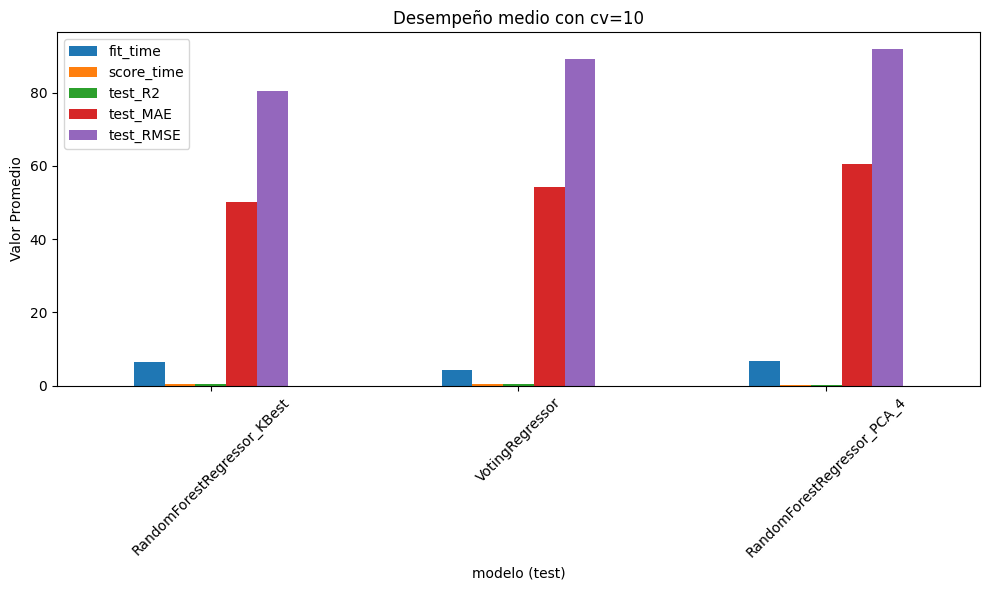

In [93]:
df_val_general.plot(kind='bar', figsize=(10,6))
plt.title("Desempeño medio con cv=10")
plt.ylabel("Valor Promedio")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [94]:
df_resultados_times = df_resultados[['modelo (test)', 'fit_time', 'score_time']]
df_val_metricas_time = df_resultados_times.melt(id_vars='modelo (test)', var_name='metric', value_name='score')
df_val_metricas_time


df_resultados_scores = df_resultados[['modelo (test)', 'test_R2', 'test_MAE', 'test_RMSE']]

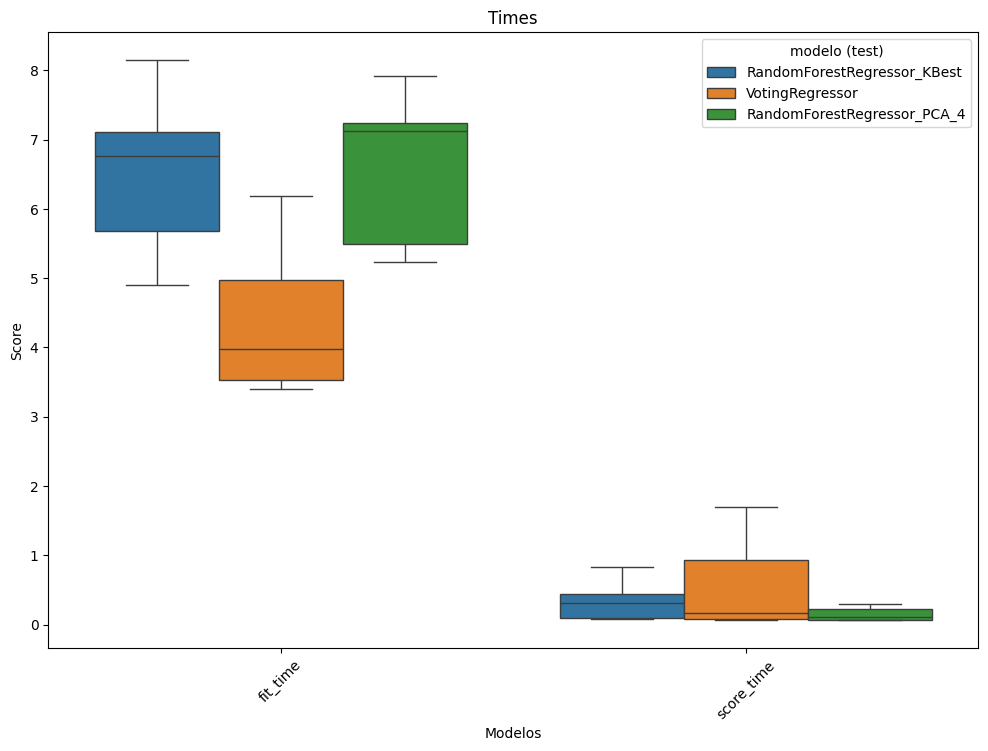

In [95]:
plt.figure(figsize=(12,8))
sns.boxplot(x='metric', y='score', hue='modelo (test)', data=df_val_metricas_time)
plt.title("Times")
plt.xlabel("Modelos")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()

In [96]:
df_resultados_scores = df_resultados[['modelo (test)', 'test_R2', 'test_MAE', 'test_RMSE']]

df_val_metricas_score = df_resultados_scores.melt(id_vars='modelo (test)', var_name='metric', value_name='score')


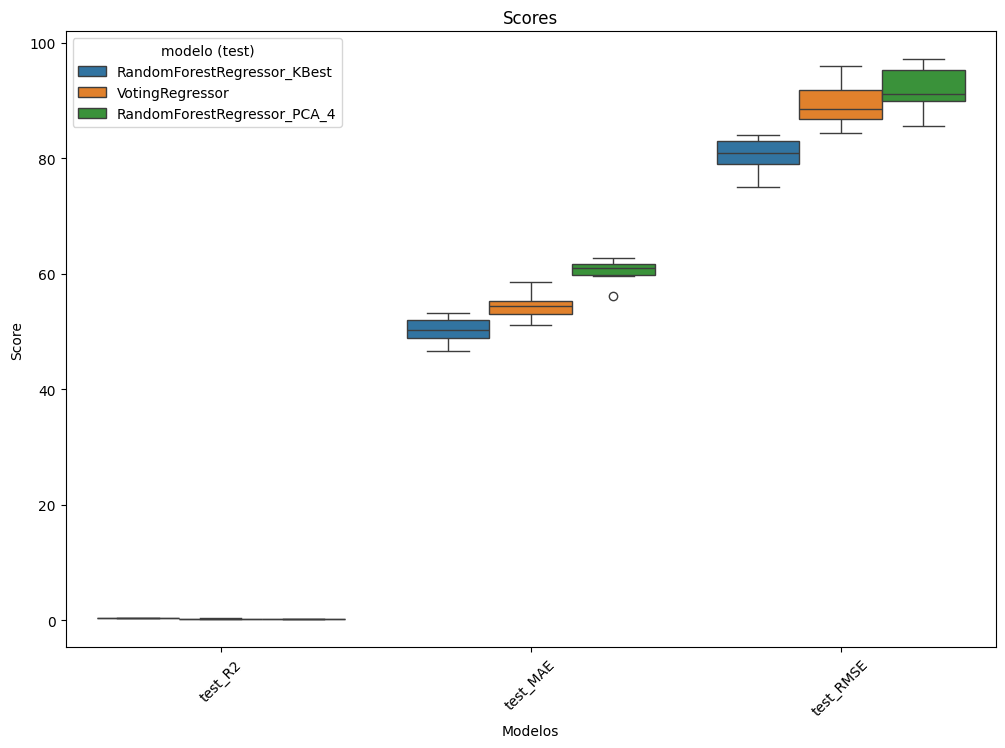

In [97]:
plt.figure(figsize=(12,8))
sns.boxplot(x='metric', y='score', hue='modelo (test)', data=df_val_metricas_score)
plt.title("Scores")
plt.xlabel("Modelos")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()